In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from misc import *
%load_ext autoreload
%autoreload 2





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
covs = []
means = []
signals = []
xicovs = []

#define parameters
gamma = 1.0 #damping from outside 
Gamma = 0.8 #measurement rate
eta = 1 # measurement efficiency
n = 2 # number of photons?
w = 0.4 # hamornic oscillator freq mecanical
m = 1 # mass harmonic oscillator mechanical
T = 2*np.pi/w

C= np.array([[np.sqrt(4*eta*Gamma), 0] ,[0, np.sqrt(4*eta*Gamma)]])

A = np.array([
    [0., 1/m],
    [-m*w**2, 0.]])

D = np.array([[gamma*(n + 0.5) + Gamma, 0], [0,gamma*(n + 0.5) + Gamma]])

## initial condition
su = n + 0.5 + Gamma/gamma
cov_in = np.array([[np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma), 0],
                   [0,np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma)]])
x_in = np.array([1,0])



dt = 5e-4
tfinal = 20
tot_steps = int(tfinal/dt)

xi = lambda cov: np.dot(cov, ct(C)) #+ ct(Gamma_matrix)

covs = [cov_in]
means = [x_in]
xicovs = [xi(covs[-1])]
for k in tqdm(range(tot_steps)):
    
    x = means[-1]
    cov = covs[-1]
    XiCov = xicovs[-1]

    dy = np.dot(C, x + np.dot(np.linalg.inv(C), np.random.randn(2)/np.sqrt(dt)))*dt # signal
    signals.append(dy)
    
    dx = np.dot(A - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    
    covs.append(covs[-1] + dcov)
    means.append(means[-1] + dx)
    xicovs.append(xi(covs[-1]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:01<00:00, 32937.29it/s]


In [7]:
import os 
os.makedirs("data", exist_ok=True)
np.save("data/means",np.array(means) )
np.save("data/covs",np.array(covs) )
np.save("data/signals",np.array(signals) )
np.save("data/xicovs",np.array(xicovs) )
np.save("data/D",D)
np.save("data/C",C)
np.save("data/dt",np.array([dt]))
np.save("data/A",A)

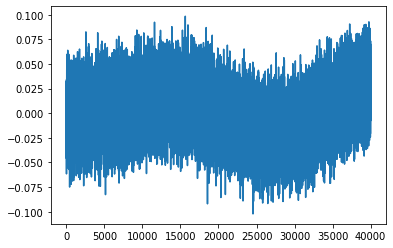

In [8]:
plt.plot([signals[k][0] for k in range(len(signals))])

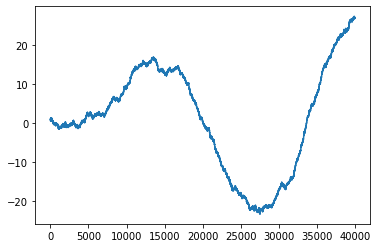

In [9]:
plt.plot([means[k][0] for k in range(len(means))])

In [12]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2021-11-26 17:55:39.998650: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


False

In [13]:
 tf.config.list_physical_devices("GPU")

[]

In [9]:
from models import *

quantities = [A, xicovs, means, signals, C, dt]
    
model = ModelA(quantities)
tfsignals = tf.cast(tf.convert_to_tensor(signals), np.float32)


In [66]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), loss="mse")

In [68]:
with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    A_pred = model.spit_A()
    dx0 = A_pred - tf.einsum('tij,jl->til',model.tfxicovs[:-1], model.C)
    dx1 = tf.einsum('tij,tj->ti', dx0, model.tfmeans[:-1])*model.dt
    dx2 = dx1 + tf.einsum('tik,tk->ti', model.tfxicovs[:-1], model.tfsignals)
    x = dx2 + model.tfmeans[:-1]    #this gives tfmeansx[1:]
    lt1 = tf.einsum('ij,tj->ti',model.C,x)*model.dt
    loss = tf.keras.losses.MeanSquaredError()(lt1[:-1], model.tfsignals[1:])

grads = tape.gradient(loss, model.trainable_variables)


In [69]:
grads

[<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
 array([[-2.3759282e-12, -2.4385522e-12,  1.7074296e-12,  1.4422804e-12,
          1.3319681e-11,  4.9773033e-12,  5.8760245e-13,  2.1806775e-12,
          1.0515628e-13,  1.0407146e-12,  1.9296423e-13,  3.7475869e-12,
         -5.7878828e-12,  5.2441228e-12, -1.5413325e-11,  7.9889472e-12,
          9.4066803e-12, -1.1695531e-12, -8.1135723e-12, -1.9889711e-11,
         -6.0270933e-12,  3.4509346e-12, -2.7491687e-12,  1.3281228e-12,
         -1.1921321e-11,  2.0493724e-12,  3.4116159e-13,  3.8500960e-12,
         -4.9658875e-12,  7.3727023e-12, -5.8650628e-12, -1.0011222e-11]],
       dtype=float32)>,
 <tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([-2.3759282e-12, -2.4385522e-12,  1.7074296e-12,  1.4422804e-12,
         1.3319681e-11,  4.9773033e-12,  5.8760245e-13,  2.1806775e-12,
         1.0515628e-13,  1.0407146e-12,  1.9296423e-13,  3.7475869e-12,
        -5.7878828e-12,  5.2441228e-12, -1.5413325e-11,  7.9889472e-12,
    

In [6]:
history = model.fit(x = tfsignals, y = tfsignals, epochs=200, batch_size=len(tfsignals), 
                   callbacks = [tf.keras.callbacks.EarlyStopping(monitor='total_loss', patience=100, mode="min", min_delta=0.0)])

NameError: name 'model' is not defined

In [64]:
model.spit_A()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 6.8723707, -1.2892938],
       [ 7.00585  ,  3.904284 ]], dtype=float32)>

In [50]:
loss

<tf.Tensor: shape=(), dtype=float64, numpy=0.0005015095230191946>